*Time Series Forecasting*

The provided CSV file includes several time series related to energy market data in Texas (ERCOT). These belong to several categories, including: day-ahead locational marginal price (DALMP) of electricity, wind plant electricity generation, electricity load and generation, ambient temperature, and others.

Given this dataset, train and benchmark the performance of a forecast model for `HB_HOUSTON (DALMP)`, the day-ahead market price for electricity in Houston, TX. Specifically, for each date `d`, use all data up to `HOURENDING` = 11 on `d` to predict the 24 price values (`HOURENDING` = 1, ..., 24) on the following date `d+1`. You may use any of the other columns in the dataset to derive features, but do not incorporate any external data sources.

In addition to code cells and their output, please include in your submitted notebook a clear explanation of your thought process and your interpretation of the results.

Please complete as much as possible of the following within the allotted time:

(a) Characterize the provided dataset. How would you interpret the relationships between the time series in the dataset? What patterns are relevant to understanding the behavior of `HB_HOUSTON (DALMP)`? Provide evidence.

(b) Train and evaluate a forecast model to predict `HB_HOUSTON (DALMP)`. Justify your evaluation methodology.

(c) Where does your forecast model demonstrate the worst performance, and how would you explain this?  What additional data would you use to augment the current data set to improve performance?

(d) The use case for this forecast is to determine when an energy storage system should charge and discharge to take advantage of variation in electricity prices. Given this, what other considerations are important for designing and evaluating the forecast model?





In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import time

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [4]:
# read the data

df = pd.read_csv('market_data_df.csv')
df.shape

(8784, 27)

In [5]:
# showing top 3 observations

df.head(3)

,Unnamed: 0,DATETIME,HB_HOUSTON (DALMP),GR_ERCOT (WIND_RTI),GR_PANHANDLE (WIND_RTI),GR_COASTAL (WIND_RTI),GR_SOUTH (WIND_RTI),GR_NORTH (WIND_RTI),GR_WEST (WIND_RTI),WZ_ERCOT (RTLOAD),WZ_Coast (RTLOAD),WZ_East (RTLOAD),WZ_FarWest (RTLOAD),WZ_North (RTLOAD),WZ_NorthCentral (RTLOAD),WZ_SouthCentral (RTLOAD),WZ_Southern (RTLOAD),WZ_West (RTLOAD),TX - El Paso/Intl (TEMP_F),TX - Houston/Intercontinental (TEMP_F),ERCOT (GEN_RESOURCE),Henry (GASPRICE),HOURENDING,MARKETDAY,PEAKTYPE,MONTH,YEAR
0,0,2020-09-30 01:00:00,11.25,11026.04,1577.95,25.53,840.71,618.14,7963.71,32230.32,9466.64,1103.49,3474.35,721.60,9146.48,4887.44,2477.51,952.83,60.1,57.9,47779.8,1.691,1,09/30/2020,NaN,SEPTEMBER,2020
1,1,2020-09-30 02:00:00,9.39,11519.25,1970.73,70.00,882.34,799.20,7796.98,30902.57,9135.20,1023.14,3492.14,720.60,8666.72,4608.16,2365.45,891.15,59.0,57.0,47866.5,1.691,2,09/30/2020,NaN,SEPTEMBER,2020
2,2,2020-09-30 03:00:00,5.90,11220.64,2320.01,100.92,859.02,848.29,7092.40,30103.53,8914.63,1008.98,3490.22,723.89,8363.25,4436.00,2281.30,885.24,63.0,55.9,47819.4,1.691,3,09/30/2020,NaN,SEPTEMBER,2020


In [6]:
# removing unnamed column as it does not posses any information

del df[df.columns[0]]

In [11]:
# change the dtype of 'DATETIME' from object to datatime

df['DATETIME'] = pd.to_datetime(df['DATETIME'])

# extracting "DATE" & "TIME" from "DATETIME"

df['DATE'] = df['DATETIME'].dt.floor('D')
df['TIME'] = pd.to_datetime(df['DATETIME'].dt.time.astype(str), format='%H:%M:%S')

# "TIME" will have a default date '1900-01-01', to remove this date from "TIME" we'll extract only the time component

df['TIME'] = df['DATETIME'].dt.time.apply(lambda x: time(x.hour, x.minute, x.second))


In [12]:
# re-arranging columns

df = df [[ 'DATETIME', 'DATE', 'TIME', 'HOURENDING', 'HB_HOUSTON (DALMP)', 'MARKETDAY', 'GR_ERCOT (WIND_RTI)',
       'GR_PANHANDLE (WIND_RTI)', 'GR_COASTAL (WIND_RTI)',
       'GR_SOUTH (WIND_RTI)', 'GR_NORTH (WIND_RTI)', 'GR_WEST (WIND_RTI)',
       'WZ_ERCOT (RTLOAD)', 'WZ_Coast (RTLOAD)', 'WZ_East (RTLOAD)',
       'WZ_FarWest (RTLOAD)', 'WZ_North (RTLOAD)', 'WZ_NorthCentral (RTLOAD)',
       'WZ_SouthCentral (RTLOAD)', 'WZ_Southern (RTLOAD)', 'WZ_West (RTLOAD)',
       'TX - El Paso/Intl (TEMP_F)', 'TX - Houston/Intercontinental (TEMP_F)',
       'ERCOT (GEN_RESOURCE)', 'Henry (GASPRICE)', 'PEAKTYPE',
       'MONTH', 'YEAR' ]]

df.head()

,DATETIME,DATE,TIME,HOURENDING,HB_HOUSTON (DALMP),MARKETDAY,GR_ERCOT (WIND_RTI),GR_PANHANDLE (WIND_RTI),GR_COASTAL (WIND_RTI),GR_SOUTH (WIND_RTI),GR_NORTH (WIND_RTI),GR_WEST (WIND_RTI),WZ_ERCOT (RTLOAD),WZ_Coast (RTLOAD),WZ_East (RTLOAD),WZ_FarWest (RTLOAD),WZ_North (RTLOAD),WZ_NorthCentral (RTLOAD),WZ_SouthCentral (RTLOAD),WZ_Southern (RTLOAD),WZ_West (RTLOAD),TX - El Paso/Intl (TEMP_F),TX - Houston/Intercontinental (TEMP_F),ERCOT (GEN_RESOURCE),Henry (GASPRICE),PEAKTYPE,MONTH,YEAR
0,2020-09-30 01:00:00,2020-09-30,01:00:00,1,11.25,09/30/2020,11026.04,1577.95,25.53,840.71,618.14,7963.71,32230.32,9466.64,1103.49,3474.35,721.60,9146.48,4887.44,2477.51,952.83,60.1,57.9,47779.8,1.691,NaN,SEPTEMBER,2020
1,2020-09-30 02:00:00,2020-09-30,02:00:00,2,9.39,09/30/2020,11519.25,1970.73,70.00,882.34,799.20,7796.98,30902.57,9135.20,1023.14,3492.14,720.60,8666.72,4608.16,2365.45,891.15,59.0,57.0,47866.5,1.691,NaN,SEPTEMBER,2020
2,2020-09-30 03:00:00,2020-09-30,03:00:00,3,5.90,09/30/2020,11220.64,2320.01,100.92,859.02,848.29,7092.40,30103.53,8914.63,1008.98,3490.22,723.89,8363.25,4436.00,2281.30,885.24,63.0,55.9,47819.4,1.691,NaN,SEPTEMBER,2020
3,2020-09-30 04:00:00,2020-09-30,04:00:00,4,5.39,09/30/2020,11170.28,2456.07,136.21,945.12,888.14,6744.74,29752.37,8861.42,1012.50,3470.18,734.79,8214.84,4340.20,2233.98,884.45,57.9,57.0,47739.2,1.691,NaN,SEPTEMBER,2020
4,2020-09-30 05:00:00,2020-09-30,05:00:00,5,5.91,09/30/2020,11465.83,2545.12,184.12,1040.59,970.29,6725.71,30082.29,8967.94,1029.37,3438.87,735.69,8330.76,4412.02,2214.03,953.61,55.9,55.9,47602.9,1.691,NaN,SEPTEMBER,2020


In [13]:
# dropping 'DATETIME', 'MONTH', 'YEAR' , 'PEAKTYPE' feature

df.drop(['DATETIME', 'MONTH', 'YEAR', 'PEAKTYPE'], axis=1, inplace = True)

In [14]:
# making "DATE" as our index

df.set_index('DATE', inplace=True)
df.head()

,TIME,HOURENDING,HB_HOUSTON (DALMP),MARKETDAY,GR_ERCOT (WIND_RTI),GR_PANHANDLE (WIND_RTI),GR_COASTAL (WIND_RTI),GR_SOUTH (WIND_RTI),GR_NORTH (WIND_RTI),GR_WEST (WIND_RTI),WZ_ERCOT (RTLOAD),WZ_Coast (RTLOAD),WZ_East (RTLOAD),WZ_FarWest (RTLOAD),WZ_North (RTLOAD),WZ_NorthCentral (RTLOAD),WZ_SouthCentral (RTLOAD),WZ_Southern (RTLOAD),WZ_West (RTLOAD),TX - El Paso/Intl (TEMP_F),TX - Houston/Intercontinental (TEMP_F),ERCOT (GEN_RESOURCE),Henry (GASPRICE)
DATE,,,,,,,,,,,,,,,,,,,,,,,
2020-09-30,01:00:00,1,11.25,09/30/2020,11026.04,1577.95,25.53,840.71,618.14,7963.71,32230.32,9466.64,1103.49,3474.35,721.60,9146.48,4887.44,2477.51,952.83,60.1,57.9,47779.8,1.691
2020-09-30,02:00:00,2,9.39,09/30/2020,11519.25,1970.73,70.00,882.34,799.20,7796.98,30902.57,9135.20,1023.14,3492.14,720.60,8666.72,4608.16,2365.45,891.15,59.0,57.0,47866.5,1.691
2020-09-30,03:00:00,3,5.90,09/30/2020,11220.64,2320.01,100.92,859.02,848.29,7092.40,30103.53,8914.63,1008.98,3490.22,723.89,8363.25,4436.00,2281.30,885.24,63.0,55.9,47819.4,1.691
2020-09-30,04:00:00,4,5.39,09/30/2020,11170.28,2456.07,136.21,945.12,888.14,6744.74,29752.37,8861.42,1012.50,3470.18,734.79,8214.84,4340.20,2233.98,884.45,57.9,57.0,47739.2,1.691
2020-09-30,05:00:00,5,5.91,09/30/2020,11465.83,2545.12,184.12,1040.59,970.29,6725.71,30082.29,8967.94,1029.37,3438.87,735.69,8330.76,4412.02,2214.03,953.61,55.9,55.9,47602.9,1.691


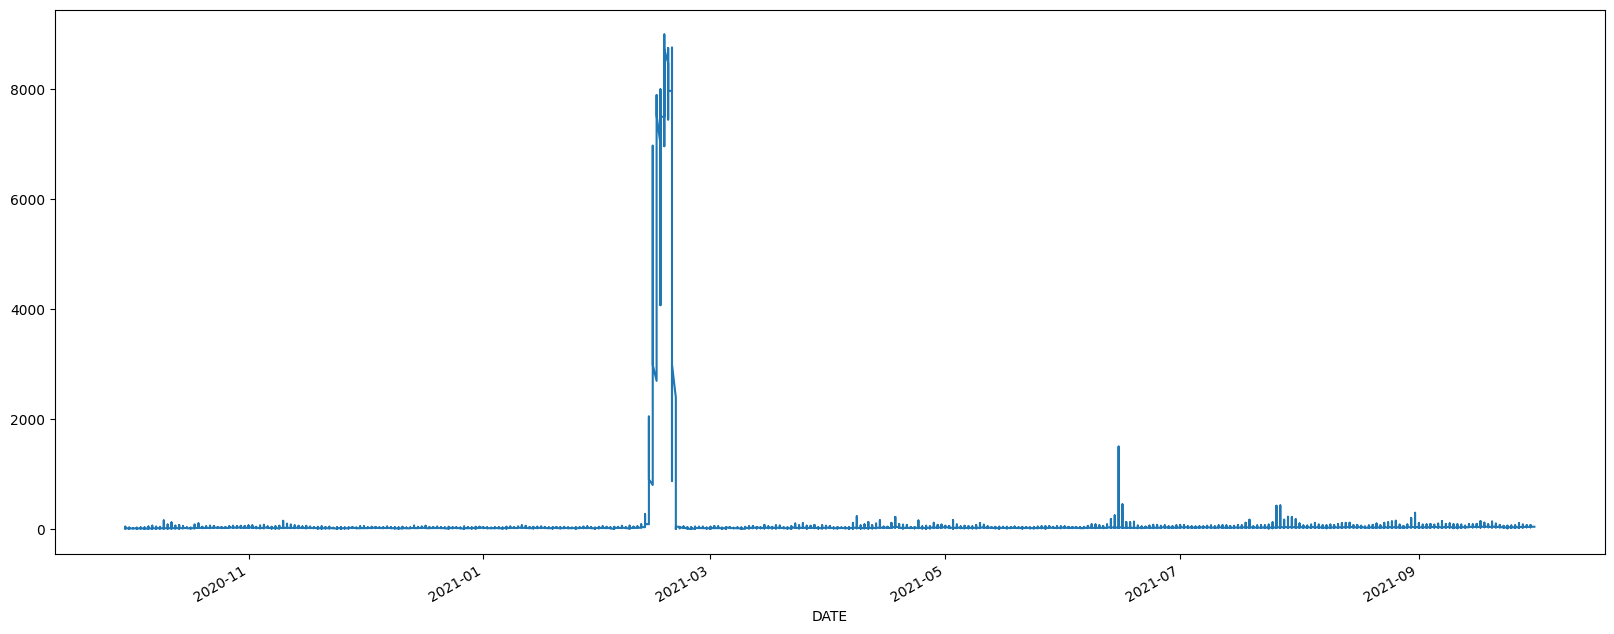

In [15]:
df['HB_HOUSTON (DALMP)'].plot(figsize=(20,8))
plt.show()

In [16]:
# fill missing values with mean

for i in df.columns[df.isnull().any(axis=0)]:
    df[i].fillna(df[i].mean(),inplace=True)

df.isnull().sum()

TIME                                      0
HOURENDING                                0
HB_HOUSTON (DALMP)                        0
MARKETDAY                                 0
GR_ERCOT (WIND_RTI)                       0
GR_PANHANDLE (WIND_RTI)                   0
GR_COASTAL (WIND_RTI)                     0
GR_SOUTH (WIND_RTI)                       0
GR_NORTH (WIND_RTI)                       0
GR_WEST (WIND_RTI)                        0
WZ_ERCOT (RTLOAD)                         0
WZ_Coast (RTLOAD)                         0
WZ_East (RTLOAD)                          0
WZ_FarWest (RTLOAD)                       0
WZ_North (RTLOAD)                         0
WZ_NorthCentral (RTLOAD)                  0
WZ_SouthCentral (RTLOAD)                  0
WZ_Southern (RTLOAD)                      0
WZ_West (RTLOAD)                          0
TX - El Paso/Intl (TEMP_F)                0
TX - Houston/Intercontinental (TEMP_F)    0
ERCOT (GEN_RESOURCE)                      0
Henry (GASPRICE)                

In [17]:
# copying the dataframe
sorted_df = df.copy(deep=True)

In [18]:
# sort the dataframe by the HOURENDING column and then by the DATE index

sorted_df = sorted_df.sort_values(['HOURENDING', 'DATE'])
sorted_df.head()

,TIME,HOURENDING,HB_HOUSTON (DALMP),MARKETDAY,GR_ERCOT (WIND_RTI),GR_PANHANDLE (WIND_RTI),GR_COASTAL (WIND_RTI),GR_SOUTH (WIND_RTI),GR_NORTH (WIND_RTI),GR_WEST (WIND_RTI),WZ_ERCOT (RTLOAD),WZ_Coast (RTLOAD),WZ_East (RTLOAD),WZ_FarWest (RTLOAD),WZ_North (RTLOAD),WZ_NorthCentral (RTLOAD),WZ_SouthCentral (RTLOAD),WZ_Southern (RTLOAD),WZ_West (RTLOAD),TX - El Paso/Intl (TEMP_F),TX - Houston/Intercontinental (TEMP_F),ERCOT (GEN_RESOURCE),Henry (GASPRICE)
DATE,,,,,,,,,,,,,,,,,,,,,,,
2020-09-30,01:00:00,1,11.25,09/30/2020,11026.04,1577.95,25.53,840.71,618.14,7963.71,32230.32,9466.64,1103.49,3474.35,721.60,9146.48,4887.44,2477.51,952.83,60.1,57.9,47779.8,1.691
2020-10-01,01:00:00,1,9.91,10/01/2020,12229.13,2463.44,367.37,1782.60,585.03,7030.69,34198.42,9945.25,1172.20,3498.51,792.49,9972.59,5078.39,2670.60,1068.39,66.9,62.1,46500.7,1.631
2020-10-02,01:00:00,1,12.16,10/02/2020,9951.63,2396.25,3.21,892.80,617.90,6041.47,34845.84,10662.09,1186.83,3473.00,732.15,9366.75,5469.74,2842.01,1113.27,71.1,66.9,44808.7,1.490
2020-10-03,01:00:00,1,8.02,10/03/2020,15483.27,2379.61,337.22,1764.15,965.06,10037.23,34020.68,9855.91,1171.84,3454.92,766.12,9372.59,5298.83,2924.91,1175.58,70.0,62.1,47979.2,1.331
2020-10-04,01:00:00,1,10.64,10/04/2020,12301.66,953.87,622.84,2177.67,681.59,7865.69,35187.37,10579.44,1119.90,3379.04,709.72,9659.51,5561.92,2973.70,1204.15,66.9,62.1,46163.1,1.331


In [19]:
# %pip install statsmodels
from statsmodels.tsa.stattools import adfuller

# doing Dickey–Fuller test

def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ", dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

In [20]:
adf_test(sorted_df['HB_HOUSTON (DALMP)'])

1. ADF :  -22.73452806712981
2. P-Value :  0.0
3. Num Of Lags :  13
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 8770
5. Critical Values :
	 1% :  -3.431095862606368
	 5% :  -2.8618696218133186
	 10% :  -2.566945452713394


P-Value is smaller than 0.05.
If your p-value is less than or equal to 0.05 (the significance level), you would conclude that your result is statistically significant. This means the evidence is strong enough to reject the null hypothesis in favor of the alternative hypothesis.

### Using Automatic ARIMA

In [15]:
# !pip install pmdarima
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(df["HB_HOUSTON (DALMP)"], seasonal=False, trace=True, suppress_warnings=True, stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=106664.508, Time=13.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=107274.606, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=107008.477, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=107063.063, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=107272.606, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=106816.612, Time=4.50 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=106874.569, Time=4.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=106512.321, Time=16.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=106557.785, Time=7.57 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=17.08 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=106496.131, Time=13.12 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=15.83 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=19.51 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=106432.543, Time=23.05 sec
 ARIMA(2,1,4)(0,0,0

### AR Model

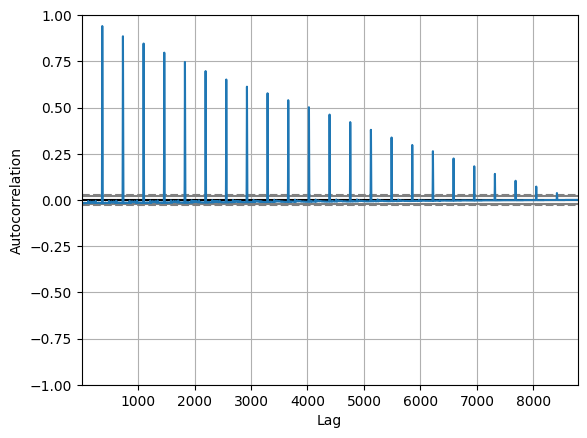

In [16]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(sorted_df["HB_HOUSTON (DALMP)"])
plt.show()

### Import ACF & PACF

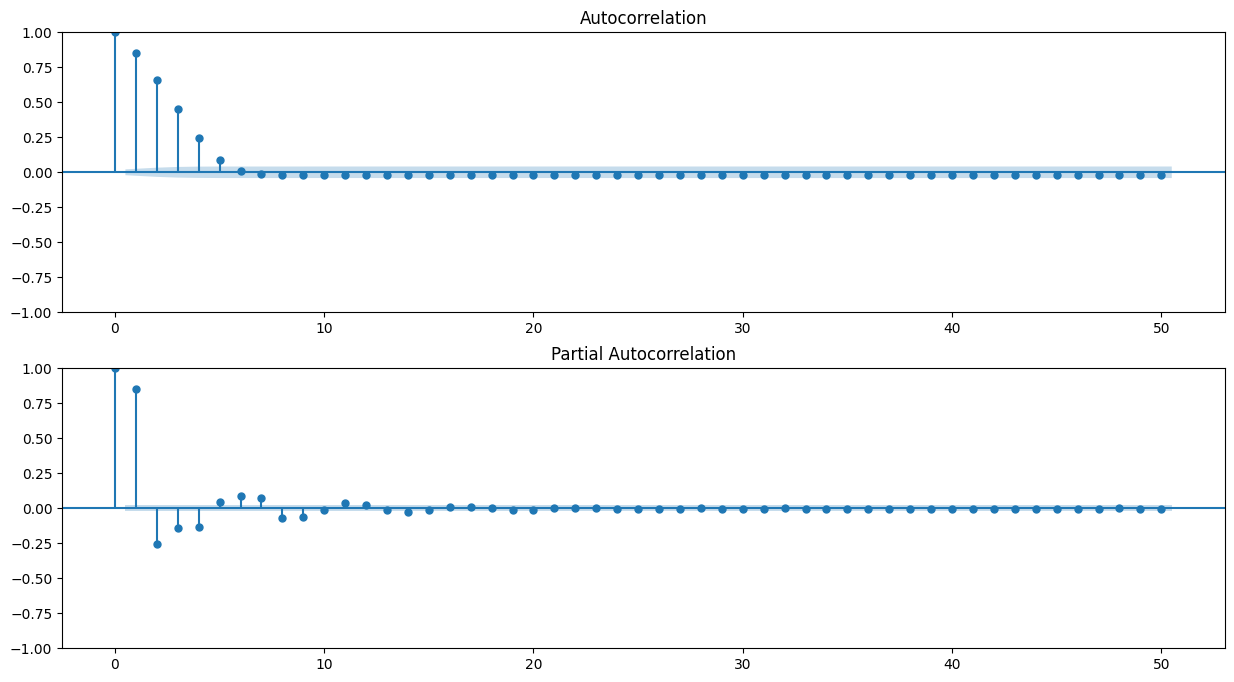

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(15,8))

# plot ACF Graph

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sorted_df['HB_HOUSTON (DALMP)'].iloc[14:], lags=50, ax=ax1)

# plot PACF Graph

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sorted_df['HB_HOUSTON (DALMP)'].iloc[14:], lags=50, ax=ax2)

### Train Test Split

In [18]:
train = sorted_df[(sorted_df['HOURENDING'] >= 1) & (sorted_df['HOURENDING'] <= 11)]
test = sorted_df[(sorted_df['HOURENDING'] >= 12) & (sorted_df['HOURENDING'] <= 24)]

print("dataframe shape ", sorted_df.shape)
print("train data shape ", train.shape)
print("test data shape ", test.shape)

dataframe shape  (8784, 23)
train data shape  (4026, 23)
test data shape  (4758, 23)


### Training the model in Train data

In [24]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train["HB_HOUSTON (DALMP)"], order = (4,1,5))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     HB_HOUSTON (DALMP)   No. Observations:                 4026
Model:                 ARIMA(4, 1, 5)   Log Likelihood              -30510.009
Date:                Sat, 13 May 2023   AIC                          61040.017
Time:                        10:45:18   BIC                          61103.020
Sample:                             0   HQIC                         61062.343
                               - 4026                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2641      0.325      0.812      0.417      -0.373       0.902
ar.L2          0.0263      0.412      0.064      0.949      -0.781       0.834
ar.L3          0.6900      0.333      2.073      0.0

### Making predictions on Test data

In [25]:
start = len(train)
end = len(train) + len(test) - 1
pred = model_fit.predict(start=start, end=end).rename('ARIMA Predictions')
pred.index = sorted_df.index[start:end+1]
print(pred)

DATE
2020-09-30     65.129115
2020-10-01     86.135391
2020-10-02    108.648428
2020-10-03    127.912559
2020-10-04    141.212368
                 ...    
2021-09-27    146.051386
2021-09-28    146.051386
2021-09-29    146.051386
2021-09-30    146.051386
2021-10-01    146.051386
Name: ARIMA Predictions, Length: 4758, dtype: float64


<Axes: xlabel='DATE'>

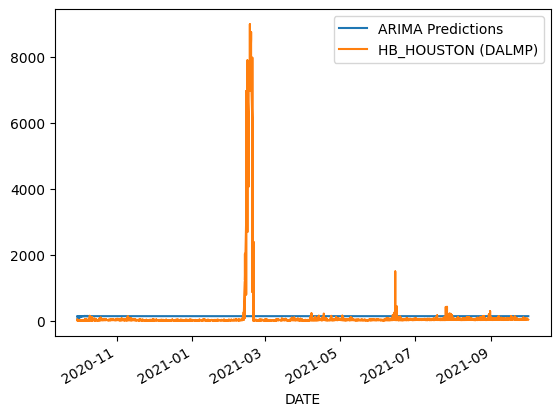

In [26]:
pred.plot(legend=True)
test["HB_HOUSTON (DALMP)"].plot(legend=True)

### Predicting Future

In [27]:
model2 = ARIMA(df["HB_HOUSTON (DALMP)"], order=(4,1,5))
model2 = model.fit()
df.tail()

,TIME,HOURENDING,HB_HOUSTON (DALMP),MARKETDAY,GR_ERCOT (WIND_RTI),GR_PANHANDLE (WIND_RTI),GR_COASTAL (WIND_RTI),GR_SOUTH (WIND_RTI),GR_NORTH (WIND_RTI),GR_WEST (WIND_RTI),WZ_ERCOT (RTLOAD),WZ_Coast (RTLOAD),WZ_East (RTLOAD),WZ_FarWest (RTLOAD),WZ_North (RTLOAD),WZ_NorthCentral (RTLOAD),WZ_SouthCentral (RTLOAD),WZ_Southern (RTLOAD),WZ_West (RTLOAD),TX - El Paso/Intl (TEMP_F),TX - Houston/Intercontinental (TEMP_F),ERCOT (GEN_RESOURCE),Henry (GASPRICE)
DATE,,,,,,,,,,,,,,,,,,,,,,,
2021-09-30,20:00:00,20,56.97,09/30/2021,12528.32,1901.47,1707.74,2595.06,641.59,5682.46,55708.42,15306.87,2197.91,4123.38,1159.65,16677.90,10130.45,4649.68,1462.56,63.0,77.0,66476.0,5.625
2021-09-30,21:00:00,21,53.41,09/30/2021,11452.69,2209.21,1198.62,2439.45,809.12,4796.29,53834.02,15005.12,2113.92,4077.66,1154.65,15811.24,9689.67,4536.27,1445.48,63.0,75.0,64620.1,5.625
2021-09-30,22:00:00,22,44.12,09/30/2021,10452.74,1924.86,932.22,2161.56,678.79,4755.31,51264.71,14502.40,1961.70,4040.17,1099.56,14843.41,9090.05,4319.71,1407.70,62.1,75.0,61033.7,5.625
2021-09-30,23:00:00,23,42.88,09/30/2021,8667.39,1341.35,942.64,1700.98,758.23,3924.19,48052.70,13776.58,1808.48,4124.25,1019.58,13704.72,8357.41,4071.47,1190.21,63.0,75.0,53880.5,5.625
2021-10-01,00:00:00,24,41.78,09/30/2021,7889.19,509.51,1090.43,1444.40,730.15,4114.70,44668.08,12994.52,1656.77,4106.33,945.06,12515.96,7645.27,3782.10,1022.06,60.1,75.0,52177.2,5.625


In [28]:
# Get the last timestamp in the DataFrame index
last_timestamp = df.index[-1]

# Increment the last timestamp by one hour to get the start of the future range
start_timestamp = last_timestamp + pd.DateOffset(hours=1)

# Create a datetime range for the next 24 hours
future_range = pd.date_range(start=start_timestamp, periods=24, freq='H')

# Predict for future hours till next 24 hours
pred = model2.predict(start = len(df) + 1, end = len(df) + 24).rename("ARIMA Predictions")

# Assign the dates as index
pred.index = future_range

print(pred)

2021-10-01 01:00:00    146.051386
2021-10-01 02:00:00    146.051386
2021-10-01 03:00:00    146.051386
2021-10-01 04:00:00    146.051386
2021-10-01 05:00:00    146.051386
2021-10-01 06:00:00    146.051386
2021-10-01 07:00:00    146.051386
2021-10-01 08:00:00    146.051386
2021-10-01 09:00:00    146.051386
2021-10-01 10:00:00    146.051386
2021-10-01 11:00:00    146.051386
2021-10-01 12:00:00    146.051386
2021-10-01 13:00:00    146.051386
2021-10-01 14:00:00    146.051386
2021-10-01 15:00:00    146.051386
2021-10-01 16:00:00    146.051386
2021-10-01 17:00:00    146.051386
2021-10-01 18:00:00    146.051386
2021-10-01 19:00:00    146.051386
2021-10-01 20:00:00    146.051386
2021-10-01 21:00:00    146.051386
2021-10-01 22:00:00    146.051386
2021-10-01 23:00:00    146.051386
2021-10-02 00:00:00    146.051386
Freq: H, Name: ARIMA Predictions, dtype: float64
